In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

Import IHSG Data

In [3]:
start_date = "2020-01-01"
end_date = "2025-11-05"

df = yf.Ticker("COIN.JK")
df = df.history(start=start_date, end=end_date)
del df["Dividends"]
del df["Stock Splits"]
forecastData = df.copy()
df.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-10-08 00:00:00+07:00,3630.0,3780.0,3410.0,3640.0,126959900
2025-10-09 00:00:00+07:00,3660.0,3780.0,3210.0,3520.0,136313400
2025-10-10 00:00:00+07:00,3510.0,3690.0,3430.0,3590.0,53659200
2025-10-13 00:00:00+07:00,3500.0,3670.0,3320.0,3430.0,128779700
2025-10-14 00:00:00+07:00,3430.0,3430.0,2920.0,2930.0,146881700
2025-10-15 00:00:00+07:00,2940.0,3240.0,2800.0,3150.0,92939200
2025-10-16 00:00:00+07:00,3170.0,3190.0,3050.0,3100.0,20374700
2025-10-17 00:00:00+07:00,3120.0,3150.0,2800.0,2860.0,28155100
2025-10-20 00:00:00+07:00,2930.0,3140.0,2930.0,3090.0,25378700


Close Price Visualitation

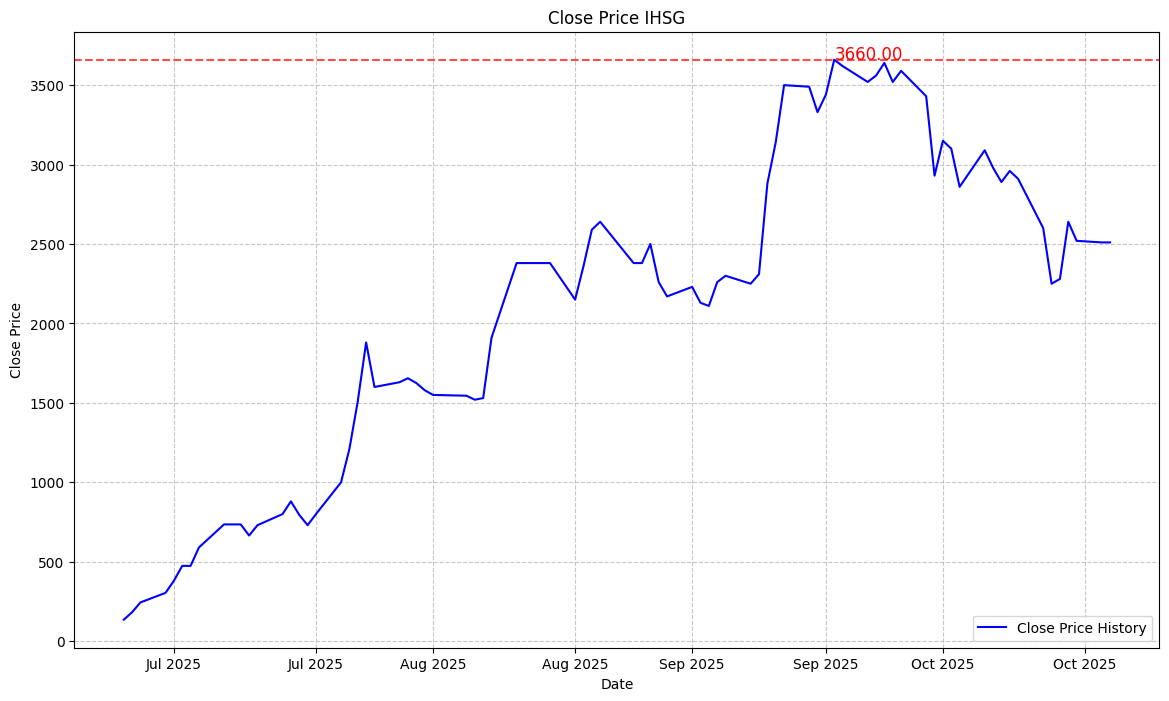

In [4]:
# Close price visualitation

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='Close', label='Close Price History', color='blue')

max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price IHSG')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Preprocessing

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[0.        ],
       [0.01333333],
       [0.03092199],
       [0.04794326],
       [0.06950355],
       [0.09617021],
       [0.09617021],
       [0.12907801],
       [0.17021277],
       [0.17021277],
       [0.17021277],
       [0.15035461],
       [0.16879433],
       [0.18865248],
       [0.21134752],
       [0.18723404],
       [0.16879433],
       [0.18865248],
       [0.24539007],
       [0.30496454],
       [0.39007092],
       [0.49503546],
       [0.41560284],
       [0.42411348],
       [0.43120567],
       [0.42269504],
       [0.40992908],
       [0.40141844],
       [0.4       ],
       [0.3929078 ],
       [0.39574468],
       [0.5035461 ],
       [0.63687943],
       [0.63687943],
       [0.63687943],
       [0.63687943],
       [0.63687943],
       [0.57163121],
       [0.63120567],
       [0.6964539 ],
       [0.7106383 ],
       [0.63687943],
       [0.63687943],
       [0.67092199],
       [0.60283688],
       [0.57730496],
       [0.59432624],
       [0.565

In [6]:
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        sequences.append(df[i:i + sequence_length])
        labels.append(df[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [7]:
sequence_length = 30

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [8]:
X_train

array([[[0.        ],
        [0.01333333],
        [0.03092199],
        ...,
        [0.40141844],
        [0.4       ],
        [0.3929078 ]],

       [[0.01333333],
        [0.03092199],
        [0.04794326],
        ...,
        [0.4       ],
        [0.3929078 ],
        [0.39574468]],

       [[0.03092199],
        [0.04794326],
        [0.06950355],
        ...,
        [0.3929078 ],
        [0.39574468],
        [0.5035461 ]],

       ...,

       [[0.63687943],
        [0.63687943],
        [0.63687943],
        ...,
        [0.98865248],
        [0.96028369],
        [0.97163121]],

       [[0.63687943],
        [0.63687943],
        [0.63687943],
        ...,
        [0.96028369],
        [0.97163121],
        [0.99432624]],

       [[0.63687943],
        [0.63687943],
        [0.57163121],
        ...,
        [0.97163121],
        [0.99432624],
        [0.96028369]]])

Training Data

In [9]:
model = Sequential()

# First Layer lSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

2025-11-05 22:02:27.123138: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-05 22:02:27.123169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-05 22:02:27.123172: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-05 22:02:27.123185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-05 22:02:27.123195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=126, validation_data=(X_test, y_test))

Epoch 1/100


2025-11-05 22:02:29.106621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6543

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(126,), dtype=float32). Expected shape (None, 30, 1), but input has incompatible shape (126,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(126,), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

Model Evaluation

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Mean Squared Error: 22807.35798550883
Root Mean Squared Error: 151.02105146471743
R2 Score: 0.9226011420691924
Mean Absolute Percentage Error: 1.7349968455803926%


Prediction Future IHSG Price in 1 Month

In [ ]:
# we choose last 30 days or data ke belakang which the reasons use (-) in sequence_length
last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted IHSG Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
Predicted IHSG Price: 8159.4052734375


In [ ]:
future_days = 30

last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

future_dates = pd.date_range(start=df.index[-1], periods=future_days+1, freq='D')[1:]

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

Visualitation IHSG Predictions

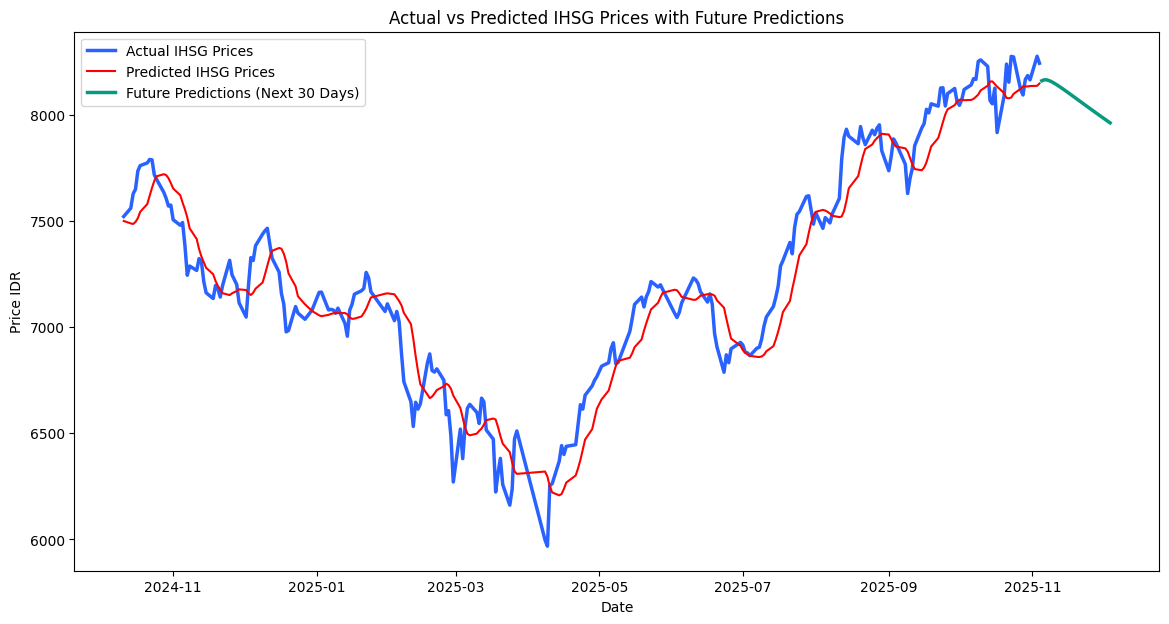

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual IHSG Prices', color='#2962ff', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted IHSG Prices', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)

plt.title('Actual vs Predicted IHSG Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price IDR')
plt.legend()
plt.show()

In [ ]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})

future_predictions_df.tail()

,Date,Predicted Price IHSG
25,2025-11-30 00:00:00+07:00,7992.621582
26,2025-12-01 00:00:00+07:00,7984.749512
27,2025-12-02 00:00:00+07:00,7976.910645
28,2025-12-03 00:00:00+07:00,7969.109863
29,2025-12-04 00:00:00+07:00,7961.338867


In [ ]:
# calculate percentage change from the last actual close price
last_actual_price = df['Close'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price IHSG'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: loss 3.40%
